In [1]:
!pip install deepchem

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.2/34.2 MB 12.3 MB/s eta 0:00:00


In [2]:
import deepchem as dc
import numpy as np
import matplotlib.pyplot as plt

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [4]:
# looks horrible right, lets simplify this more now
# here we are only seeing what's inside the dataset


tasks, datasets, transformers = dc.molnet.load_tox21()

train_dataset, valid_dataset, test_dataset = datasets

print("train -> ", train_dataset.X.shape, train_dataset.y.shape, train_dataset.w.shape)
print("valid -> ", valid_dataset.X.shape, valid_dataset.y.shape, valid_dataset.w.shape)
print("test -> ", test_dataset.X.shape, test_dataset.y.shape, test_dataset.w.shape)

train ->  (6258, 1024) (6258, 12) (6258, 12)
valid ->  (782, 1024) (782, 12) (782, 12)
test ->  (783, 1024) (783, 12) (783, 12)


# some notes before we go further!!

* what are tasks here?  
  
  -> consider this as types of targets

* why weights are also in dataset?    
  
  -> here weights are associated for each label, to reduce the bias of model

  suppose if a task has more negative samples (0) than positive ones (1), so in general the positive samples must be given more/higher weights ( just to help the model )

* what is transformer here!!  
  
  -> this is not what you thinking, it just doing transformation on the data before feeding it to the model




total number of samples ->  6258


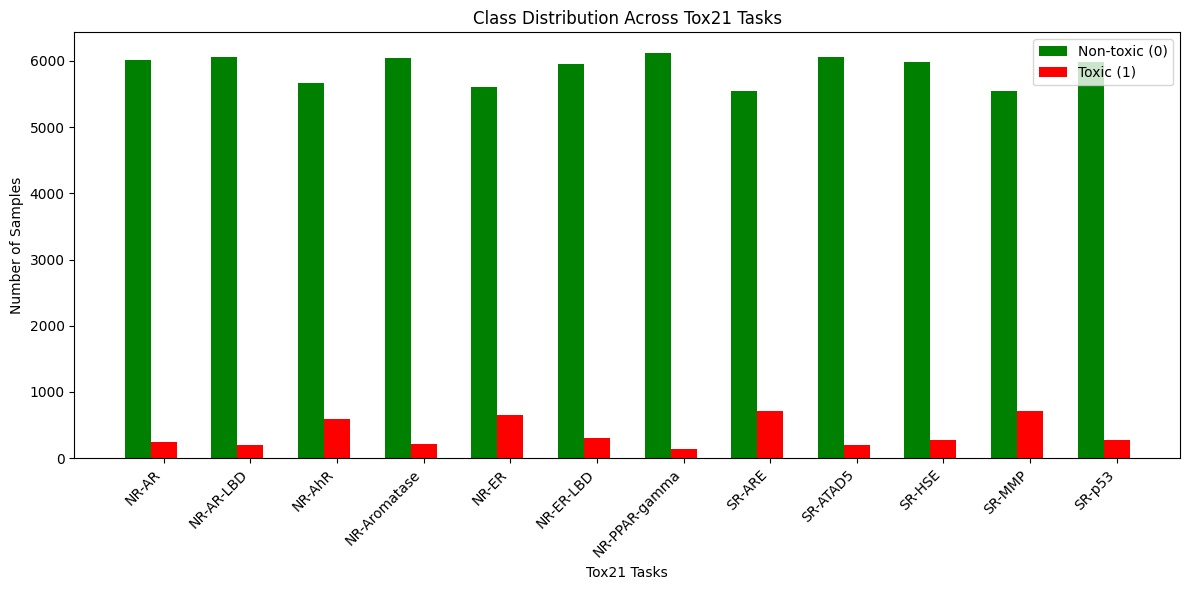

In [5]:
from collections import Counter


# for now lets visualize whats in training labels
train_labels = train_dataset.y
print("total number of samples -> ", len(train_labels))

positives = []
negatives = []



for i, names in enumerate(tasks):

  task_labels = train_labels[:, i]

  positives.append(np.sum(task_labels == 1))
  negatives.append(np.sum(task_labels == 0))




# took help from GPT to do this

x = np.arange(len(tasks))  # X-axis positions
width = 0.3  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width, negatives, width, label='Non-toxic (0)', color='green')
ax.bar(x, positives, width, label='Toxic (1)', color='red')


# Customize the plot
ax.set_xticks(x)
ax.set_xticklabels(tasks, rotation=45, ha='right')
ax.set_xlabel('Tox21 Tasks')
ax.set_ylabel('Number of Samples')
ax.set_title('Class Distribution Across Tox21 Tasks')
ax.legend()

plt.tight_layout()
plt.show()

## what is the goal of this, that we are coding!  
  

* for each input ( 1024 dimensions ) vector we are predicting a binary outcome
* 1 for toxic and 0 for non-toxic

In [6]:
# what is the goal of this, that we are coding!

# for each input ( 1024 dimensions ) vector we are predicting a binary outcome
# 1 for toxic and 0 for non-toxic

In [40]:
from deepchem.models.fcnet import MultitaskClassifier

model = MultitaskClassifier(
    n_tasks = len(tasks),
    n_features = train_dataset.X.shape[1],
    layer_sizes = [1000, 500],
    dropouts = 0.2
)




model.fit(train_dataset, nb_epoch=50)


0.056242752075195315

In [42]:
# again this is generated by GPT , took very time because of output shapes
from sklearn.metrics import roc_auc_score



y_pred_prob = model.predict(test_dataset)


y_pred_prob = y_pred_prob[:, :, 1]
y_true = test_dataset.y



print("y_pred_prob shape:", y_pred_prob.shape)
print("y_true shape:", y_true.shape)


roc_auc = roc_auc_score(y_true, y_pred_prob, average='macro', multi_class='ovr')
print(f"ROC AUC Score: {roc_auc}")


y_pred_prob shape: (783, 12)
y_true shape: (783, 12)
ROC AUC Score: 0.6523420802974774


In [ ]:
metric = dc.metrics.Metric(dc.metrics.balanced_accuracy_score, mode="classification")


scores = model.evaluate(test_dataset, [metric], [])

print(scores) 